# **Deep Learning - Abnormality Detection in bone X-Rays**

The MURA dataset is a comprehensive collection of 40,561 musculoskeletal radiographs across 14,863 studies.
The aim is to automate the diagnosis of radiographic abnormalities.

It covers a wide range of upper extremities, providing a binary classification challenge labeled by expert radiologists. This dataset is pivotal for developing and benchmarking machine learning models in medical image analysis, especially in musculoskeletal radiology.

## Our Strategy

* We will focus on two main strategies for solving the classification task. Firstly, we will train a custom CNN architecture that will try to handle the problem. Then we will utilize an already pretrained CNN that exists in Tensorflow framework.
* First of all we should import all necessary functions.

In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
import os
from glob import glob
from pathlib import Path
from typing import List, Dict, Optional, Tuple, Any, Union
import pickle
import gc
import datetime
import seaborn as sns
from sklearn.metrics import f1_score, roc_auc_score, confusion_matrix
%matplotlib inline

from tensorflow.keras import layers, models
import tensorflow as tf

# Allow memory growth on GPU devices
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)
        
from cycler import cycler
from tensorflow.random import set_seed

# Set mixed precision policy for faster running times
from tensorflow.keras import mixed_precision as mp
mp.set_global_policy("mixed_float16")
#import helper_functions as hp

#CNN_CUSTOM_PATH = r'C:\Users\maniat\OneDrive - Lyse AS\Desktop\personal\MSc\Deep Learning\OneDrive_1_3-23-2024\Project 2\custom_cnn_mura'
CNN_CUSTOM_PATH = r'custom_cnn_mura'
CNN_PRETRAIN_PATH = r'pretrained_mura'
DATASET_PATH = r'/kaggle/input/mura-v1-1'

###  1. Custom CNN Model

As a first step we developed a simple custom CNN model. 

This model has the following characteristics and architecture: 

- **Custom Architecture Details**:
  - **Input Layer**: Accepts images of shape `input_shape`.
  - **Data Augmentation**: Optional augmentation applied to input data for model robustness.
  - **Convolutional Layers**: Sequential layers with increasing filters (from 8 up to 256) and a kernel size of 3x3, each followed by batch normalization and a specified activation function.
  - **MaxPooling**: Interspersed to reduce spatial dimensions following certain convolutional layers.
  - **Global Average Pooling**: Reduces spatial dimensions to a vector.
  - **Dropout**: Included to prevent overfitting, with a rate defined by `dropout_rate`.
  - **Output Layer**: A dense layer with a single neuron, using an `output_activation` function for binary classification.


### Create Dataset to evaluate the models

* The batch size used is 8, so that the model could be trained with our limited resources.
* The MURA dataset contains variable-sized images. For the custom training we scale them to 256x256.


In [13]:
BATCH_SIZE = 8
IMG_SIZE = 256

The history saving thread hit an unexpected error (OperationalError('attempt to write a readonly database')).History will not be written to the database.


In [26]:
df_mura = hp.get_dataframes(DATASET_PATH);

In [ ]:
patients = df_mura.patient.unique()
np.random.seed(42)
np.random.shuffle(patients)

test_patients = patients[int(len(patients)*0.9):]

#Update labels
df_mura.loc[df_mura.patient.isin(test_patients), 'data_type'] = 'test'
test_df_custom = df_mura.loc[df_mura.data_type == 'test'].reset_index(drop=True)
test_dataset_custom  = hp.create_dataset(test_df_custom, batch_size = BATCH_SIZE,img_size=IMG_SIZE, custom_dataset=True)

* We runs several tests testing different learning rates and dropout rates.
* The batch size is kept to 8, for memory efficiency, in all models tested.
* The custom function `find_best_model` evaluates all the models we have trained and prints the architecture of the best one.

In [5]:
best_model_custom = hp.find_best_model(CNN_CUSTOM_PATH, test_dataset_custom)
best_model_custom.summary()

/home/vassilis/.local/lib/python3.10/site-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 



TensorFlow Addons (TFA) has ended development and introduction of new features.

TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.

Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 



For more information see: https://github.com/tensorflow/addons/issues/2807 



  warnings.warn(

2024-03-24 17:29:19.411897: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8904


Best Model: custom_cnn_mura/batch8+dropout02+DataAug+1e4_model.keras with Test Accuracy: 0.5866209268569946

Model: "model"

_________________________________________________________________

 Layer (type)                Output Shape              Param #   


 input_1 (InputLayer)        [(None, 256, 256, 1)]     0         

                                                                 

 sequential (Sequential)     (None, 256, 256, 1)       0         

                                                                 

 conv2d (Conv2D)             (None, 254, 254, 8)       72        

                                                                 

 batch_normalization (Batch  (None, 254, 254, 8)       32        

 Normalization)                                                  

                                                                 

 activation (Activation)     (None, 254, 254, 8)       0         

                                                                 

 co

### Evaluate Custom model

In [6]:
metrics = best_model_custom.evaluate(test_dataset_custom, verbose=1)

511/511 [==============================] - 14s 26ms/step - loss: 0.6836 - accuracy: 0.5866 - auc: 0.5704 - cohen_kappa: 0.1264


* We can notice that the accuracy is relatively low at 58.66% and ROC AUC metric is 0.57 indicating that the classifier has poor discrimination ability between positive and negative instances (pictures).
* We also report another metric, **Cohen's Kappa**. The metric takes values in the [-1,1] range. Kappa value of 0.1264 indicates that the predictions are slightly better that random guessing.

In [7]:
test_df_after_predictions_custom = hp.create_predictions_dataframe(best_model_custom, test_df_custom, img_size=IMG_SIZE, custom_dataset=True)

### Confusion MATRIX on a per image basis

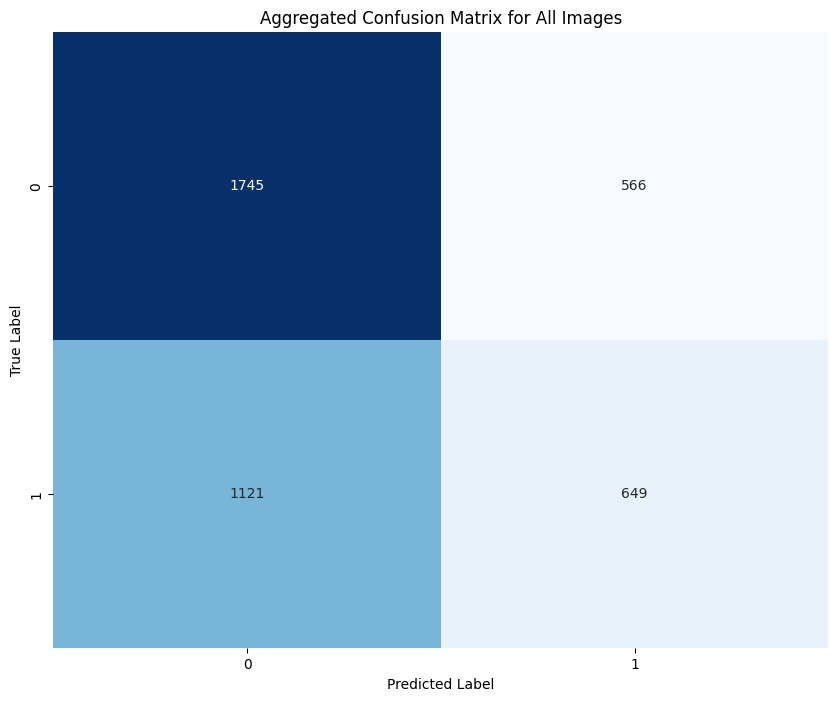

In [8]:
hp.plot_cm(test_df_after_predictions_custom)

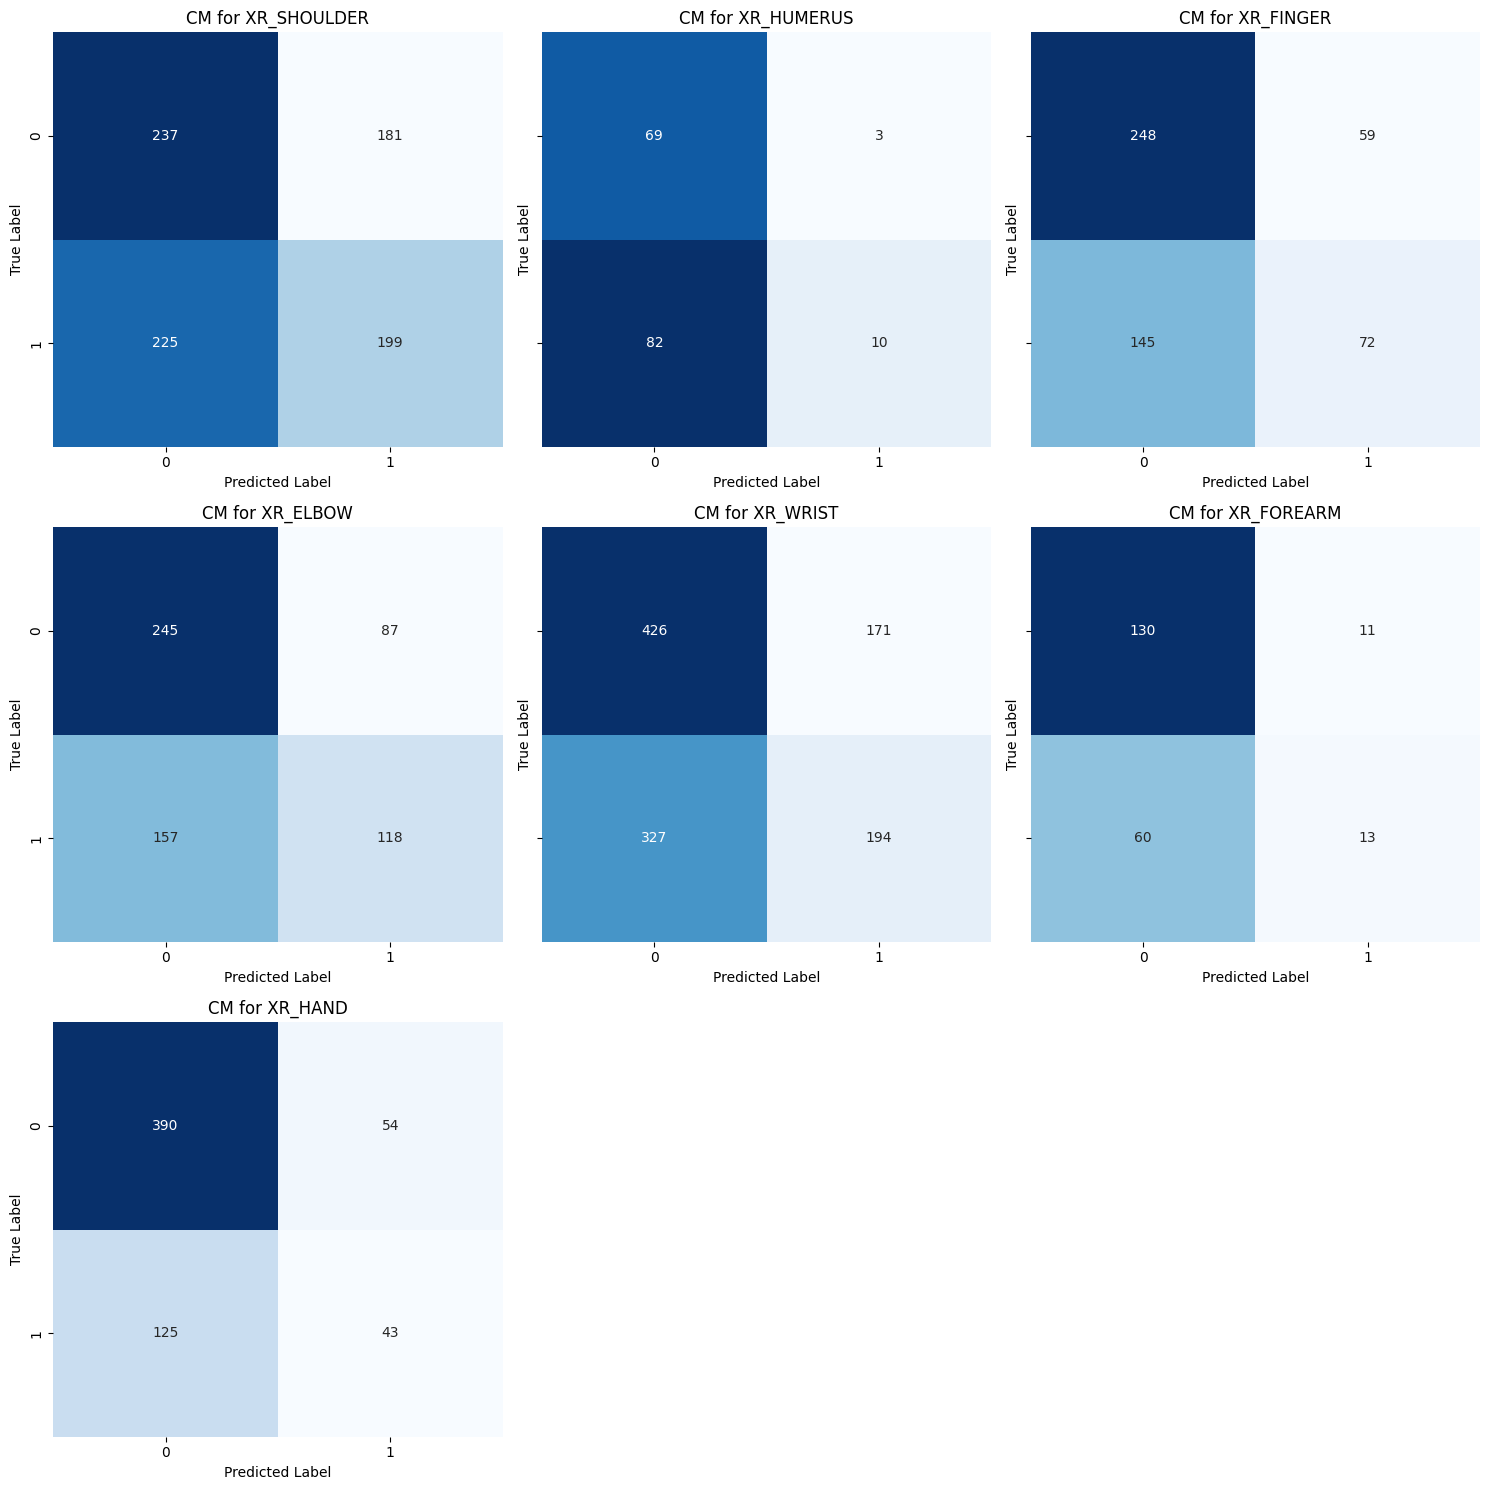

In [9]:
hp.plot_cm(test_df_after_predictions_custom,segment = True)

### Analysis on Confusion matrix

The confustion matrix on aggregate level eveals a model with a strong ability to identify the normal cases (1745 TN), but is deficient in recognizing abnormalities, leading to a high number of FN (1121). 

The FP count (566) indicates some misclassification, where the model erroneously detected conditions. 

Overall, the matrix underscores a need for improved sensitivity to reduce the risk of missed diagnoses.

For the confusion matrices per body part, we have a mixed performance. Specifically:

For the shoulder, humerus, and wrist, the model demonstrates a tendency towards high FN, suggesting a lower sensitivity for abnormalities.

On the other hand the model appears more balanced for the elbow, finger, hand, and forearm, with a closer distribution of TP and TN.
There is room for improvement and should be focused in reducing FN for the elbow and wrist, and FP for the finger and wrist, to enhance overall diagnostic precision.

In [10]:
study_df = test_df_after_predictions_custom.groupby(['patient', 'anatomy', 'path']).agg({
    'predicted_label': ['mean', 'max'], 
    'labels': 'min'
})  

study_df.columns = ['_'.join(col).rstrip('_') for col in study_df.columns.values]
study_df['pred_binary_mean'] = np.where(study_df['predicted_label_mean'] > 0.5, 1, 0)
study_df['pred_binary_max'] = np.where(study_df['predicted_label_max'] > 0.5, 1, 0) # at least one is wrong then all are wrong

### Analysis of F1 score and ROC-AUC on a per study basis

In [11]:
# Aggregate Level
f1_aggregate, roc_auc_aggregate = hp.calculate_metrics(study_df['labels_min'], study_df['pred_binary_mean'], study_df['predicted_label_max'])

print("Aggregate Level:")
print(f"F1 Score: {f1_aggregate:.4f}, ROC AUC: {roc_auc_aggregate:.4f}")

Aggregate Level:

F1 Score: 0.3865, ROC AUC: 0.5953


The model F1 score shows that the model has low to medium effectiveness to balance precision and recall while the ROC-AUC shows poor but better than random discriminative ability

### Analysis of F1 score and ROC-AUC per anatomy

In [12]:
# Per Anatomy Level
metrics_per_anatomy = study_df.groupby('anatomy').apply(
    lambda x: pd.Series(hp.calculate_metrics(x['labels_min'], x['pred_binary_mean'], x['predicted_label_max']), index=['F1', 'ROC AUC'])
)

print("\nPer Anatomy Level:")
print(metrics_per_anatomy)



Per Anatomy Level:

                   F1   ROC AUC

anatomy                        

XR_ELBOW     0.389831  0.616667

XR_FINGER    0.417391  0.675765

XR_FOREARM   0.325581  0.606205

XR_HAND      0.259740  0.645688

XR_HUMERUS   0.081633  0.620588

XR_SHOULDER  0.461538  0.492054

XR_WRIST     0.400000  0.559903


For the F1 and ROC AUC scores by body part:

The finger and shoulder exhibit better performance, with relatively higher F1 scores and ROC AUC values, suggesting more balanced precision and recall, and better class separation.

The elbow and wrist have moderate F1 scores and ROC AUC values, indicating average performance in terms of both metrics.

The forearm, hand, and humerus are on the lower end of the performance spectrum, with particularly low F1 scores and ROC AUC values for the humerus, highlighting a substantial need for model improvement for these anatomy parts.

## 2. Pretrained CNN - MobileNet

As a second step we will rely on the power of transfer learning and we will use the MobileNet network which is lightweight as it is designed to be used in mobile and embedded vision applications. It also requires less computational resources than more heavyweight pre-trained CNNs like VGG or ResNet. 

The model architecture can be summarized as follows:

- **Model Architecture**:
  - **Input**: Accepts one inputs: radiographic images of shape `(224, 224, 3)`
  - **Data Augmentation**: We created a Sequential layer applying randomly the following transformations:
      - **Random Rotation**: Applies random rotation to the input images.
      - **Random Flip**: Randomly flips the input images horizontally and vertically
      - **Random Contrast Adjustment**: Adjusts the contrast of the input images randomly.
  - **Base Model**: MobileNetV2 with weights pre-trained on ImageNet, set to be non-trainable by default to leverage feature extraction
  - **Global Average Pooling**: Applied after feature extraction to reduce dimensionality.
  - **Dense Layer**: A dense layer with units specified by the user and GeLU activation.
  - **Dropout**: Applied after the dense layer with a rate of 0.2.
  - **Output Layer**: A dense layer with a single unit and sigmoid activation for binary classification.

- **Training and Adaptation**:
  - **Fine-tuning**: Initially we run the model with all the Mobilnet's weights as untrainable. After a specific number of epochs (when the head is trained) we unfreeze the network and run it for some extra epochs.
  - **Learning Rate**: We train in general on higher learning rate for the head and with significantly lower for the full network. In all runs we utilize the `ReduceLROnPlateau` and `EarlyStopping` callback.
  - **Optimization and Loss**: Uses the Adam optimizer with binary crossentropy loss, focusing on accuracy as the primary metri, but also reporting AUC and Cohen's Kappa.

### Create Dataset to evaluate the models

* The pretrained MobiletV2 requires images with shape (224,224,3). So we need to reshape our variable-sized images to 224x224.
* In order to deal with the 3 channels that the network requires we copy the single image channel to the other two dimensions. 
* The batch size used is 8 (or in some cases tested 16), so that the model could be trained with our limited resources.

In [14]:
BATCH_SIZE = 8
IMG_SIZE = 224

In [15]:
patients = df_mura.patient.unique()
np.random.seed(42)
np.random.shuffle(patients)

test_patients = patients[int(len(patients)*0.9):]

#Update labels
df_mura.loc[df_mura.patient.isin(test_patients), 'data_type'] = 'test'
test_df_pretrained = df_mura.loc[df_mura.data_type == 'test'].reset_index(drop=True)
test_dataset_pretrained  = hp.create_dataset(test_df_pretrained, batch_size = BATCH_SIZE,
                                         img_size=IMG_SIZE, custom_dataset=False)

* We run again the `find_best_model` function to find the best, based on test accuracy from those that we run.

In [16]:
best_model_pretrained = hp.find_best_model(CNN_PRETRAIN_PATH, test_dataset_pretrained)
best_model_pretrained.summary()

Best Model: pretrained_mura/batch16+dropout02+DataAug+uplr05e4+flr1e5+218Dense_model.keras with Test Accuracy: 0.7030139565467834

Model: "model"

_________________________________________________________________

 Layer (type)                Output Shape              Param #   


 Input (InputLayer)          [(None, 224, 224, 3)]     0         

                                                                 

 sequential (Sequential)     (None, 224, 224, 3)       0         

                                                                 

 mobilenetv2_1.00_224 (Func  (None, 7, 7, 1280)        2257984   

 tional)                                                         

                                                                 

 global_average_pooling2d (  (None, 1280)              0         

 GlobalAveragePooling2D)                                         

                                                                 

 Hidden-1 (Dense)            (None, 218)        

* The best model using this technique used for training a batch size of **16**, Data Augmentation is enabled, dropout rate at 0.2 and 218 units in the Dense head layer. The initial learning rate used for the upper layers is $5e^{-5}$ and $1e^{-5}$ for the finetuning.

### Evaluate Pretrained model

In [21]:
metrics = best_model_pretrained.evaluate(test_dataset_pretrained, verbose=1)

511/511 [==============================] - 5s 10ms/step - loss: 0.5888 - accuracy: 0.7030


* The accuracy has been drastically improved compared to our simple custom CNN, and it is now 70.30%.
* **NOTE** Unfortunately we didn't track auc and kappa in this run, but we calculate some metrics below.

In [23]:
test_df_after_predictions_pretrained = hp.create_predictions_dataframe(best_model_pretrained, test_df_pretrained, img_size=IMG_SIZE, custom_dataset=False)

### Plot Training history

#### Load history

In [29]:
# File paths
upper_history_path = "pretrained_mura/batch16+dropout02+DataAug+uplr05e4+flr1e5+218Dense_history_upper.keras"
full_history_path = "pretrained_mura/batch16+dropout02+DataAug+uplr05e4+flr1e5+218Dense_history_full.keras"

# Load the training history from the upper model
with open(upper_history_path, 'rb') as file:
    best_model_pretrained_hs_upper = pickle.load(file)

# Load the training history from the full model
with open(full_history_path, 'rb') as file:
    best_model_pretrained_hs_full = pickle.load(file)

In [32]:
print("Upper Layers Evaluation:")
print("---")
print("Train Loss     : {0:.5f}".format(best_model_pretrained_hs_upper.history['loss'][-1]))
print("Validation Loss: {0:.5f}".format(best_model_pretrained_hs_upper.history['val_loss'][-1]))
print("---")
print("Train Accuracy     : {0:.5f}".format(best_model_pretrained_hs_upper.history['accuracy'][-1]))
print("Validation Accuracy: {0:.5f}".format(best_model_pretrained_hs_upper.history['val_accuracy'][-1]))


print("Full Network Evaluation:")
print("---")
print("Train Loss     : {0:.5f}".format(best_model_pretrained_hs_full.history['loss'][-1]))
print("Validation Loss: {0:.5f}".format(best_model_pretrained_hs_full.history['val_loss'][-1]))
print("---")
print("Train Accuracy     : {0:.5f}".format(best_model_pretrained_hs_full.history['accuracy'][-1]))
print("Validation Accuracy: {0:.5f}".format(best_model_pretrained_hs_full.history['val_accuracy'][-1]))

Upper Layers Evaluation:

---

Train Loss     : 0.46692

Validation Loss: 0.57454

---

Train Accuracy     : 0.78117

Validation Accuracy: 0.70267

Full Network Evaluation:

---

Train Loss     : 0.32407

Validation Loss: 0.60218

---

Train Accuracy     : 0.86944

Validation Accuracy: 0.68809


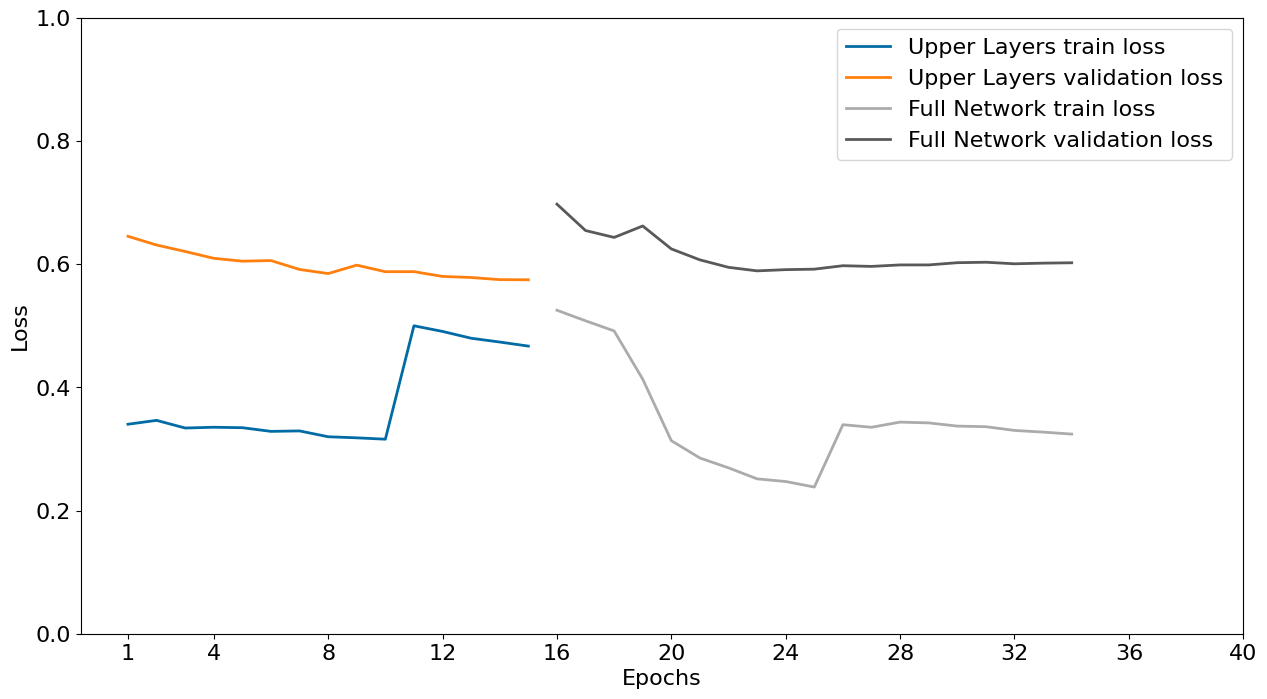

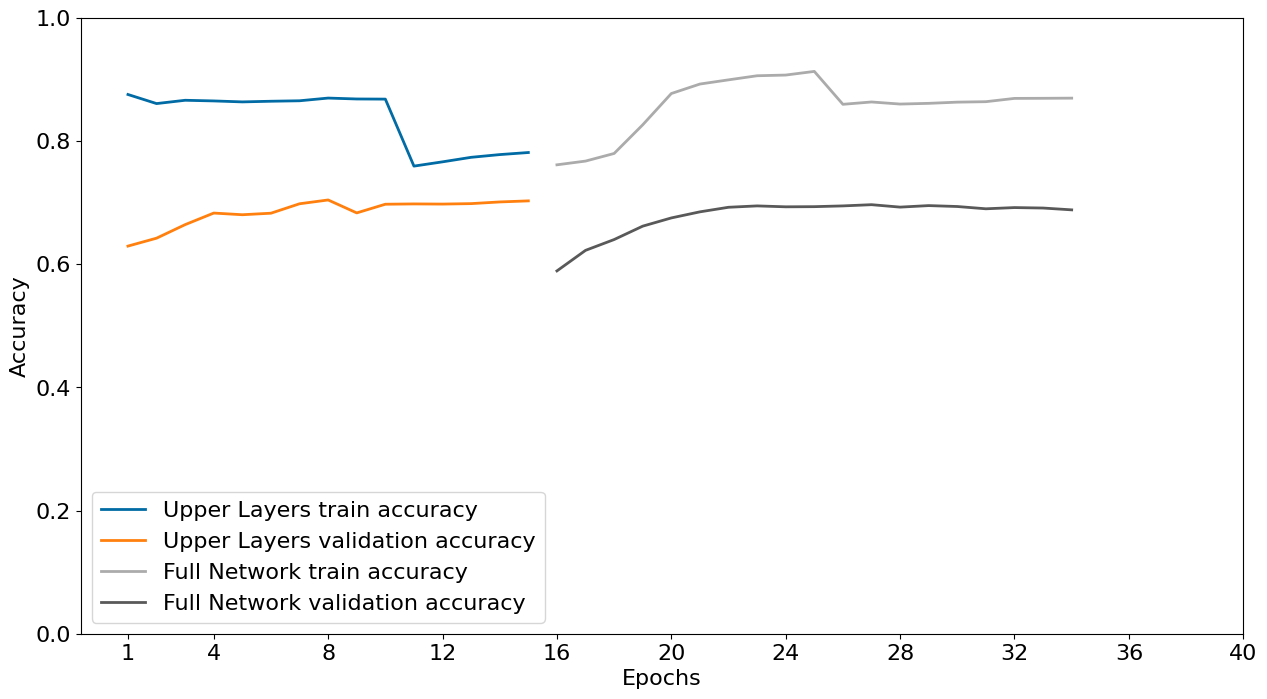

In [36]:
hp.plot_history(
    hs={
        'Upper Layers': {'history': best_model_pretrained_hs_upper, 'x_start': 1},
        'Full Network': {'history': best_model_pretrained_hs_full, 'x_start': len(best_model_pretrained_hs_upper.history['loss']) + 1}
    },
    epochs=40,
    metric='loss',
    max_y=1
)
hp.plot_history(
    hs={
        'Upper Layers': {'history': best_model_pretrained_hs_upper, 'x_start': 1},
        'Full Network': {'history': best_model_pretrained_hs_full, 'x_start': len(best_model_pretrained_hs_upper.history['loss']) + 1}
    },
    epochs=40,
    metric='accuracy',
    max_y=1
)

### Confusion MATRIX on a per image basis

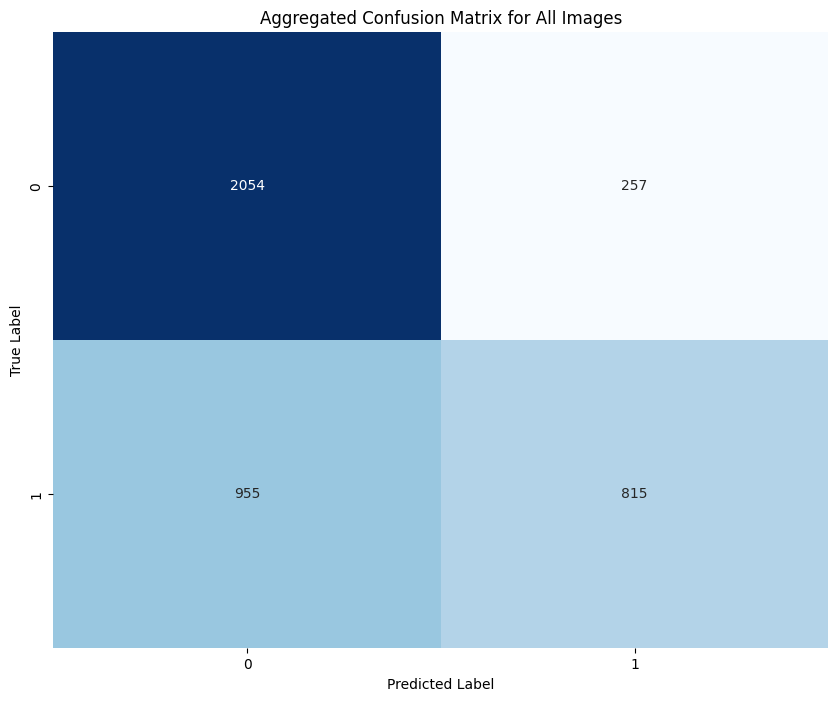

In [24]:
hp.plot_cm(test_df_after_predictions_pretrained)

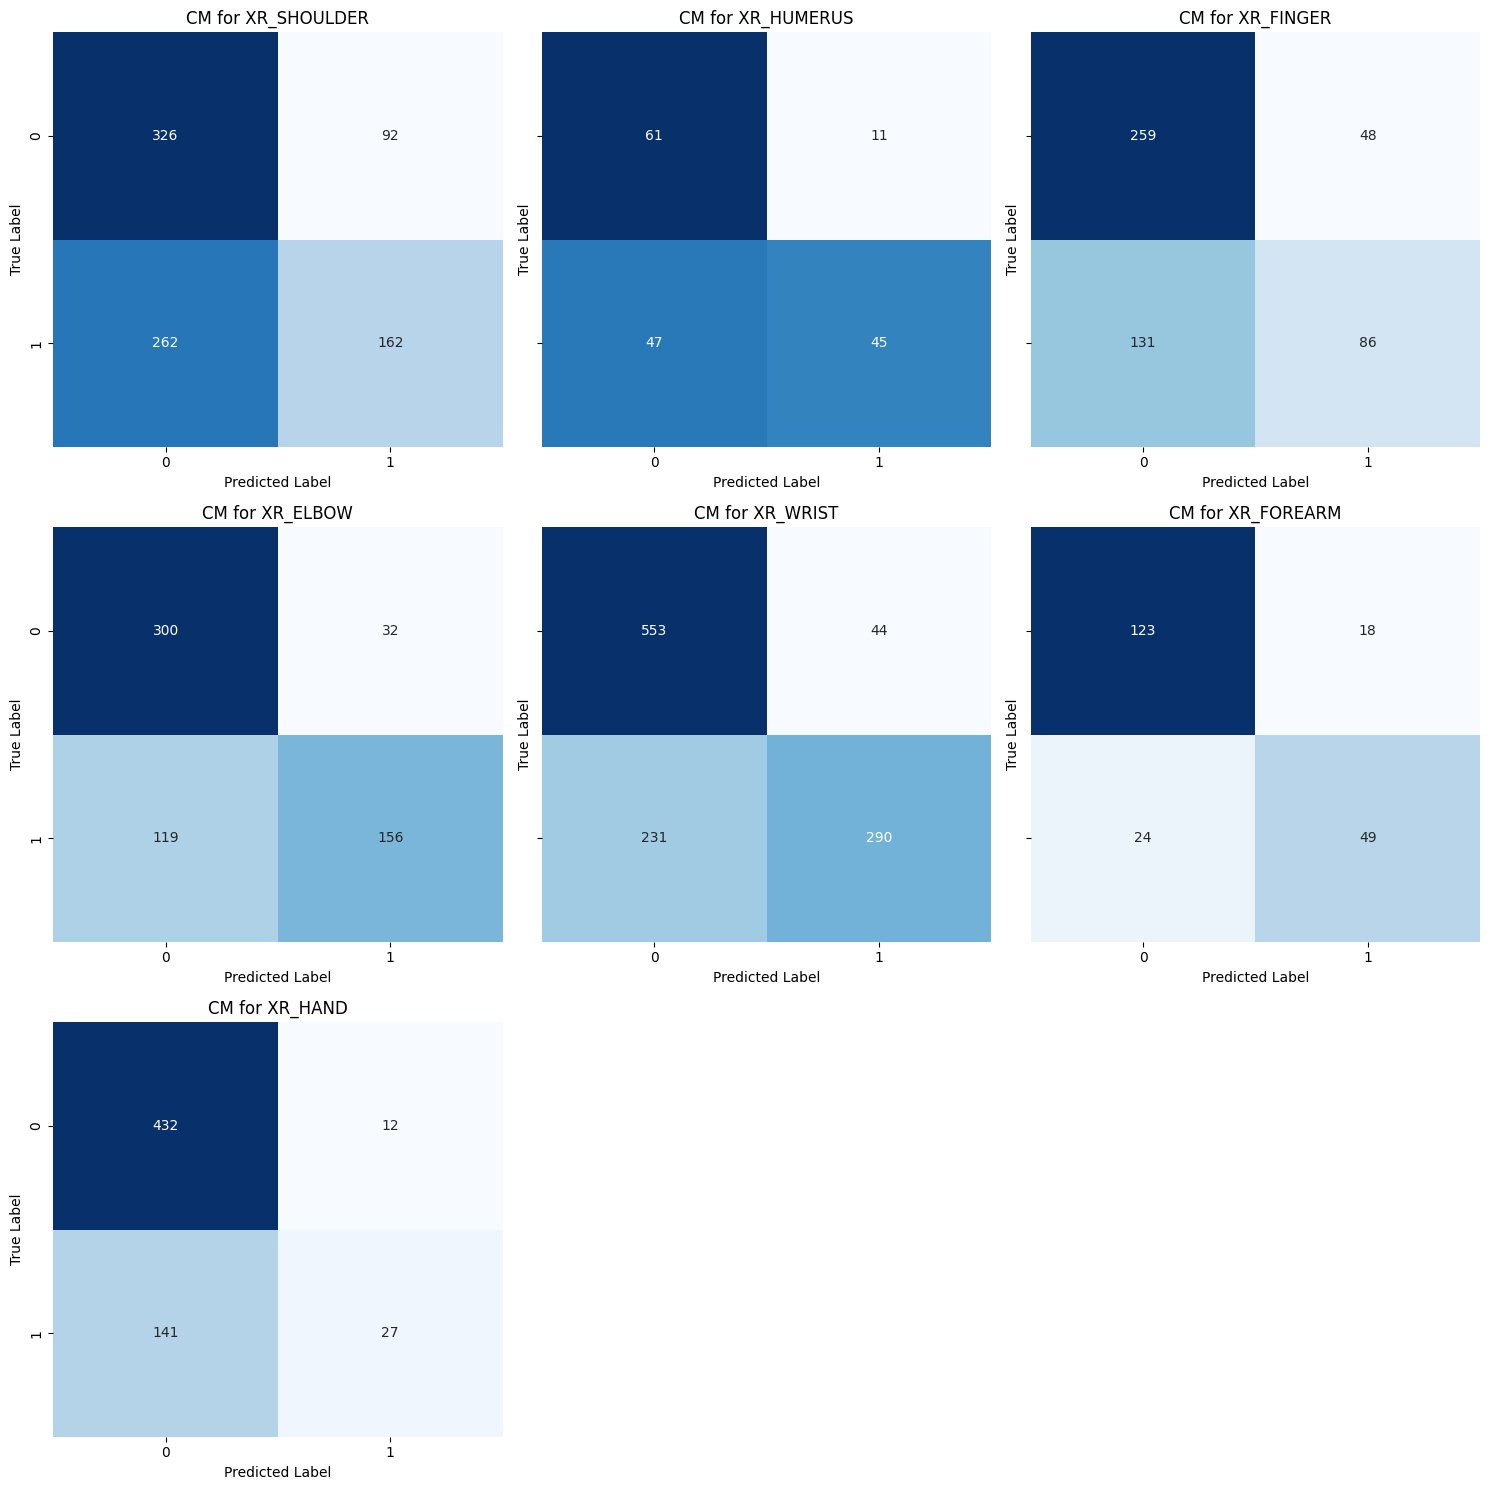

In [25]:
hp.plot_cm(test_df_after_predictions_pretrained,segment = True)

### Analysis on Confusion matrix

The updated confusion matrix indicates of the pre-trained model shows improved performance in identifying the abnormal cases, with TP increasing to 815. Compared to the previous matrix, both TN and TP have increased, indicating better overall performance. FP have decreased to 257, while FN remain higher at 955, suggesting that while there is improvement, the model still tends to miss abnormal cases. The feature extraction from the pre-trained model is the main contributor to this improvment in performance. 



Comparing the confusion matrices from the pretrained model to the custom model we see that :


- **XR_SHOULDER**: The current matrix shows an increase in TN and FN and a slight decrese in TP.

- **XR_HUMERUS**: There is a noticeable improvement in the TP

- **XR_FINGER**: TP have increased, while FP have decreased slightly, which shows a better specificity

- **XR_ELBOW**: TP have increased, while FP have decreased slightly, which shows a better specificity

- **XR_WRIST**: TP have increased significantly, with a reduction in FN , pointing to a substantial improvement.

- **XR_FOREARM**: TP have more than tripled, and FP,FN have decreased, reflecting a notable improvement.

- **XR_HAND**: TP have decreased shightly while FN have decreased, showing worse performance.

The current confusion matrices illustrate that the pre-trained model generally performs better across all body parts except Shoulder and Hand, with more reliable predictions.

In [26]:
study_df = test_df_after_predictions_pretrained.groupby(['patient', 'anatomy', 'path']).agg({
    'predicted_label': ['mean', 'max'], 
    'labels': 'min'
})  

study_df.columns = ['_'.join(col).rstrip('_') for col in study_df.columns.values]
study_df['pred_binary_mean'] = np.where(study_df['predicted_label_mean'] > 0.5, 1, 0)
study_df['pred_binary_max'] = np.where(study_df['predicted_label_max'] > 0.5, 1, 0) # at least one is wrong then all are wrong

### Analysis of F1 score and ROC-AUC on a per study basis

In [27]:
# Aggregate Level
f1_aggregate, roc_auc_aggregate = hp.calculate_metrics(study_df['labels_min'], study_df['pred_binary_mean'], study_df['predicted_label_max'])

print("Aggregate Level:")
print(f"F1 Score: {f1_aggregate:.4f}, ROC AUC: {roc_auc_aggregate:.4f}")

Aggregate Level:

F1 Score: 0.5919, ROC AUC: 0.7883


* Both F1 and ROC AUC scores are drastically improved.

### Analysis of F1 score and ROC-AUC per anatomy

In [28]:
# Per Anatomy Level
metrics_per_anatomy = study_df.groupby('anatomy').apply(
    lambda x: pd.Series(hp.calculate_metrics(x['labels_min'], x['pred_binary_mean'], x['predicted_label_max']), index=['F1', 'ROC AUC'])
)

print("\nPer Anatomy Level:")
print(metrics_per_anatomy)



Per Anatomy Level:

                   F1   ROC AUC

anatomy                        

XR_ELBOW     0.676923  0.813924

XR_FINGER    0.527273  0.787877

XR_FOREARM   0.800000  0.847826

XR_HAND      0.215385  0.664130

XR_HUMERUS   0.631579  0.743137

XR_SHOULDER  0.426540  0.638606

XR_WRIST     0.732394  0.865121


* The metrics are also improved for the specific Anatomy. The parts with the smallest improvement are Hand, Shoulder, Humerus.

## 3. Anatomy added as feature - MobileNet

We created an additional network that utilizes MobileNet without further pretraining, incorporating anatomical features as extra inputs, as we observed that classification accuracy appears to be dependent on different anatomical factors.

As this model seemed the most hopeful in terms of performance we took the time to run this for 100 epocs. The results are below:

In [12]:
# File paths
history_path = "/kaggle/working/mobilenetfrozen_final_anatomy_v8_history.pkl"

# Load the training history from the upper model
with open(history_path, 'rb') as file:
    model_pretrained_extra_history = pickle.load(file)

### Plot history

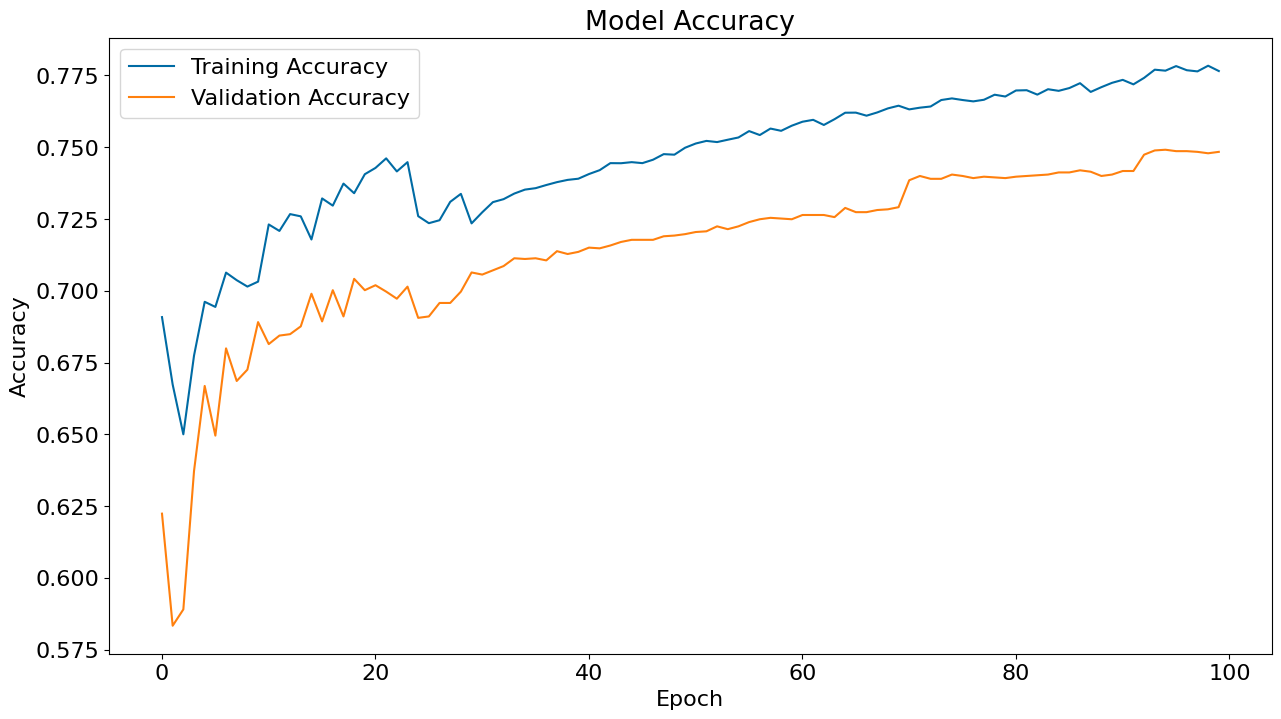

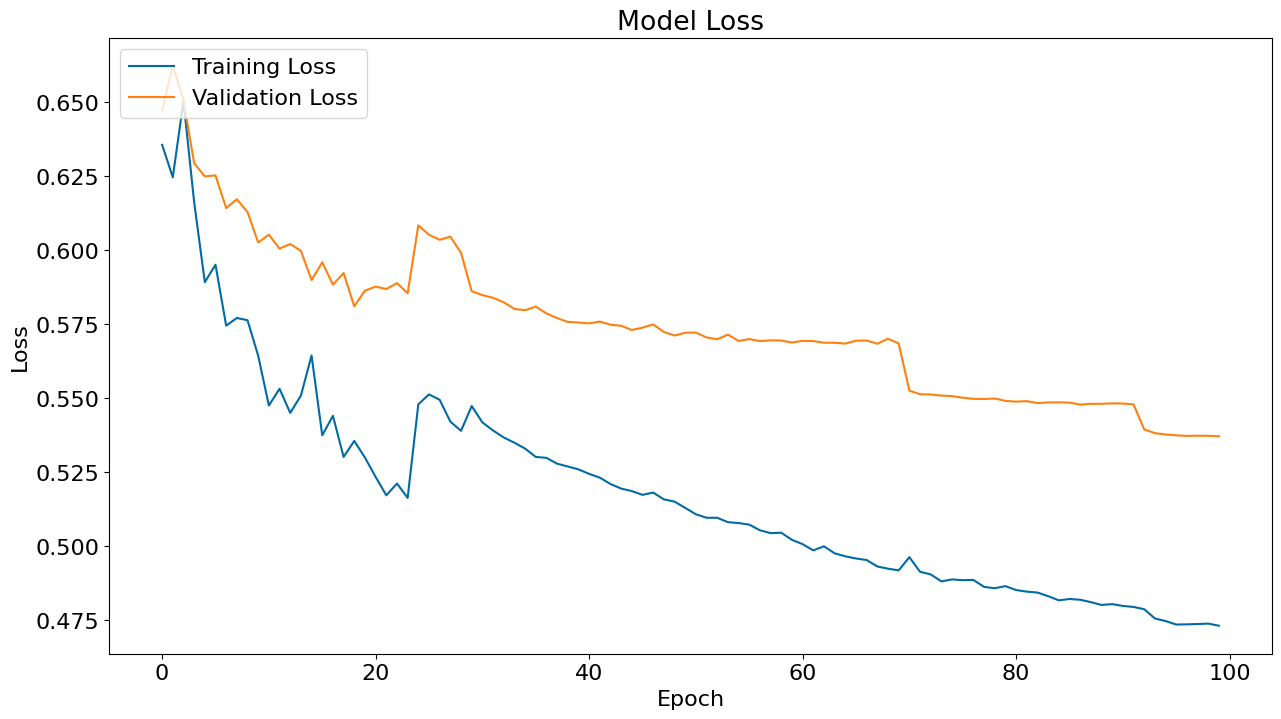

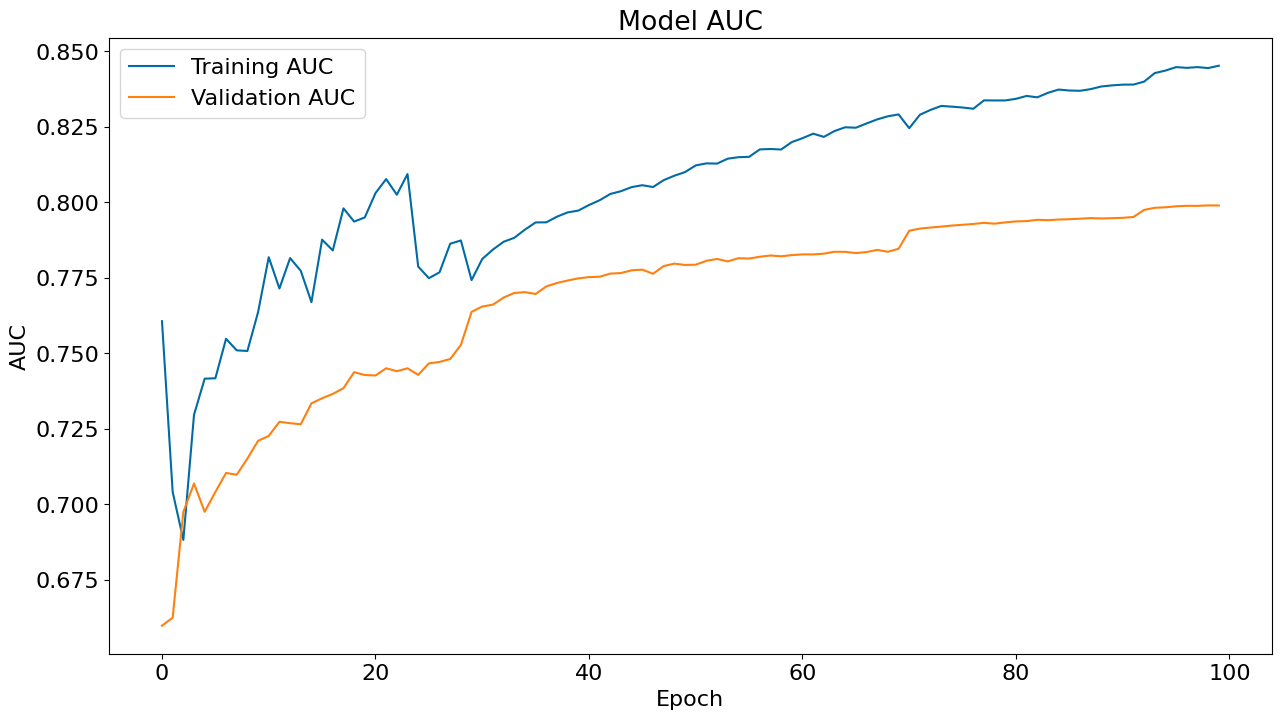

In [15]:
history = model_pretrained_extra_history

accuracy_key = 'accuracy'  
loss_key = 'loss'

# Keys for AUC
auc_key = 'auc'
val_auc_key = 'val_auc'

plt.rcParams['figure.figsize'] = [15, 8]
plt.rcParams['font.size'] = 16
plt.clf()
   
# Change background to white
plt.style.use('tableau-colorblind10')

# Plot accuracy
plt.rcParams['figure.figsize'] = [15, 8]
plt.rcParams['font.size'] = 16
plt.clf()
plt.plot(history[accuracy_key], label='Training Accuracy')
plt.plot(history['val_' + accuracy_key], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(loc='upper left')
plt.show()

# Plot loss
plt.rcParams['figure.figsize'] = [15, 8]
plt.rcParams['font.size'] = 16
plt.clf()
plt.plot(history[loss_key], label='Training Loss')
plt.plot(history['val_' + loss_key], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(loc='upper left')
plt.show()

# Plot AUC
plt.rcParams['figure.figsize'] = [15, 8]
plt.rcParams['font.size'] = 16
plt.clf()
plt.plot(history[auc_key], label='Training AUC')
plt.plot(history[val_auc_key], label='Validation AUC')
plt.title('Model AUC')
plt.ylabel('AUC')
plt.xlabel('Epoch')
plt.legend(loc='upper left')
plt.show()

### Load and evaluate Pretrained model Extra

* the new model is trained in a diferent way so we need to change are custom `create_dataset` function that creates the test dataset.

In [3]:
BATCH_SIZE = 32
IMG_SIZE = 224

def load_and_preprocess_image(path):
    image = tf.io.read_file(path)
    image = tf.image.decode_png(image, channels=1)  # Decode as grayscale
    image = tf.image.resize(image, [IMG_SIZE, IMG_SIZE])/255 # rescaling added
    image = tf.tile(image, [1, 1, 3])  # Replicate grayscale image across three channels
    return image

def create_dataset2(df, batch_size=BATCH_SIZE, augment=False):
    # Images
    image_paths = df['image_paths'].values
    image_dataset = tf.data.Dataset.from_tensor_slices(image_paths)
    image_dataset = image_dataset.map(load_and_preprocess_image, num_parallel_calls=tf.data.AUTOTUNE)
    
    # Anatomy vectors
    anatomy_to_index = {anatomy: idx for idx, anatomy in enumerate(df['anatomy'].unique())}
    anatomy_indices = df['anatomy'].map(anatomy_to_index).values
    anatomy_vectors = tf.one_hot(anatomy_indices, depth=len(anatomy_to_index))
    anatomy_dataset = tf.data.Dataset.from_tensor_slices(anatomy_vectors)

    # Labels
    labels = df['labels'].values
    label_dataset = tf.data.Dataset.from_tensor_slices(labels)
    
    # Combine into a single dataset
    dataset = tf.data.Dataset.zip(((image_dataset, anatomy_dataset), label_dataset))
    
    if augment:
        dataset = dataset.map(apply_augmentation, num_parallel_calls=tf.data.AUTOTUNE)
    
    # Batching
    dataset = dataset.batch(batch_size)
    
    # Prefetch
    dataset = dataset.prefetch(buffer_size=tf.data.AUTOTUNE)

    return dataset

In [8]:
FOLDER_PATH = r'/kaggle/input/mura-v1-1/MURA-v1.1'
base_path = Path(FOLDER_PATH)
os.chdir(base_path.parent)
os.getcwd()
df_mura = get_dataframes(FOLDER_PATH)
patients = df_mura.patient.unique()
np.random.seed(42)
np.random.shuffle(patients)

test_patients = patients[int(len(patients)*0.9):]

#Update labels
df_mura.loc[df_mura.patient.isin(test_patients), 'data_type'] = 'test'
test_df_extra = df_mura.loc[df_mura.data_type == 'test'].reset_index(drop=True)
test_dataset_extra  = create_dataset2(test_df_extra, batch_size = BATCH_SIZE)

In [16]:
# Load Model

model_path = "/kaggle/working/mobilenetfrozen_final_anatomy_v8_model.keras"

model_extra = tf.keras.models.load_model(model_path)

model_extra.summary()

/opt/conda/lib/python3.10/site-packages/keras/src/saving/saving_lib.py:396: UserWarning: Skipping variable loading for optimizer 'loss_scale_optimizer', because it has 326 variables whereas the saved optimizer has 10 variables. 
  trackable.load_own_variables(weights_store.get(inner_path))
/opt/conda/lib/python3.10/site-packages/keras/src/saving/saving_lib.py:396: UserWarning: Skipping variable loading for optimizer 'adam', because it has 322 variables whereas the saved optimizer has 0 variables. 
  trackable.load_own_variables(weights_store.get(inner_path))


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ mobilenetv2_1.00_2… │ (None, 7, 7,      │  2,257,984 │ input_layer_1[0]… │
│ (Functional)        │ 1280)             │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_average_poo… │ (None, 1280)      │          0 │ mobilenetv2_1.00… │
│ (GlobalAveragePool… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ input_layer_2       │ (None, 7)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ concatenate         │ (None, 1287)      │          0 │ global_average_p… │
│ (Concatenate)       │                   │            │ input_layer_2[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 128)       │    164,864 │ concatenate[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout (Dropout)   │ (None, 128)       │          0 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 1)         │        129 │ dropout[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 7,200,713 (27.47 MB)

 Trainable params: 2,388,865 (9.11 MB)

 Non-trainable params: 34,112 (133.25 KB)

 Optimizer params: 4,777,736 (18.23 MB)

In [17]:
metrics_anatomy = model_extra.evaluate(test_dataset_extra, verbose=1)

  3/128 ━━━━━━━━━━━━━━━━━━━━ 9s 77ms/step - accuracy: 0.6111 - auc: 0.9370 - loss: 0.5753 

I0000 00:00:1711387391.671559      82 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


128/128 ━━━━━━━━━━━━━━━━━━━━ 27s 148ms/step - accuracy: 0.7106 - auc: 0.8070 - loss: 0.5706


We achieve an accuracy of 71% on the test set, with AUC around 80% which means that the model has good discriminative performance. 

### Confusion MATRIX on a per image basis

In [24]:
predictions = model_extra.predict(test_dataset_extra, verbose=0)
test_df_extra_after_prediction = test_df_extra.assign(predicted_label=predictions, 
                                              pred_binary=(predictions > 0.5).astype(int))


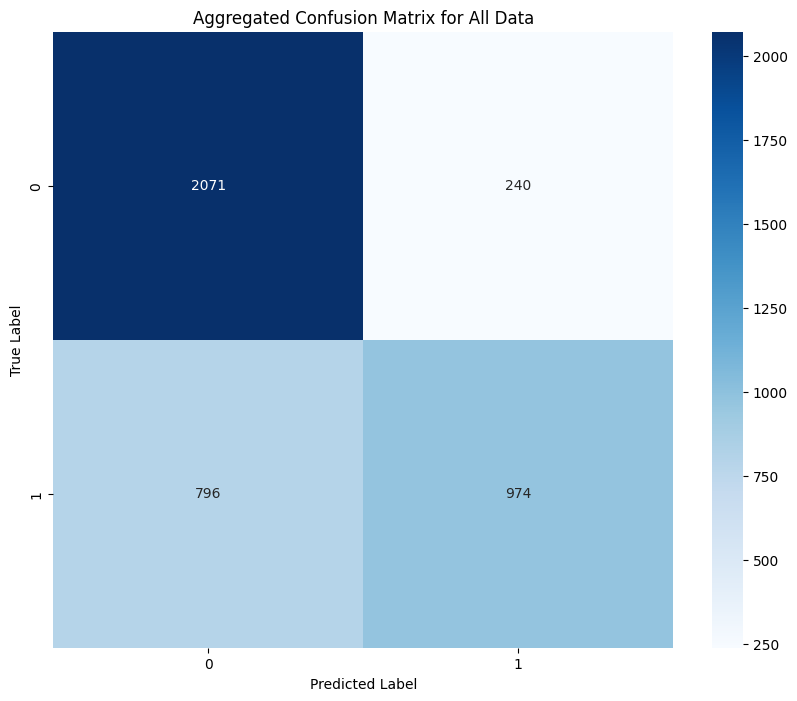

In [25]:
hp.plot_cm(test_df_extra_after_prediction)

For the aggregate confusion matrix, we observe more TP reduced FN than in the previous models. 

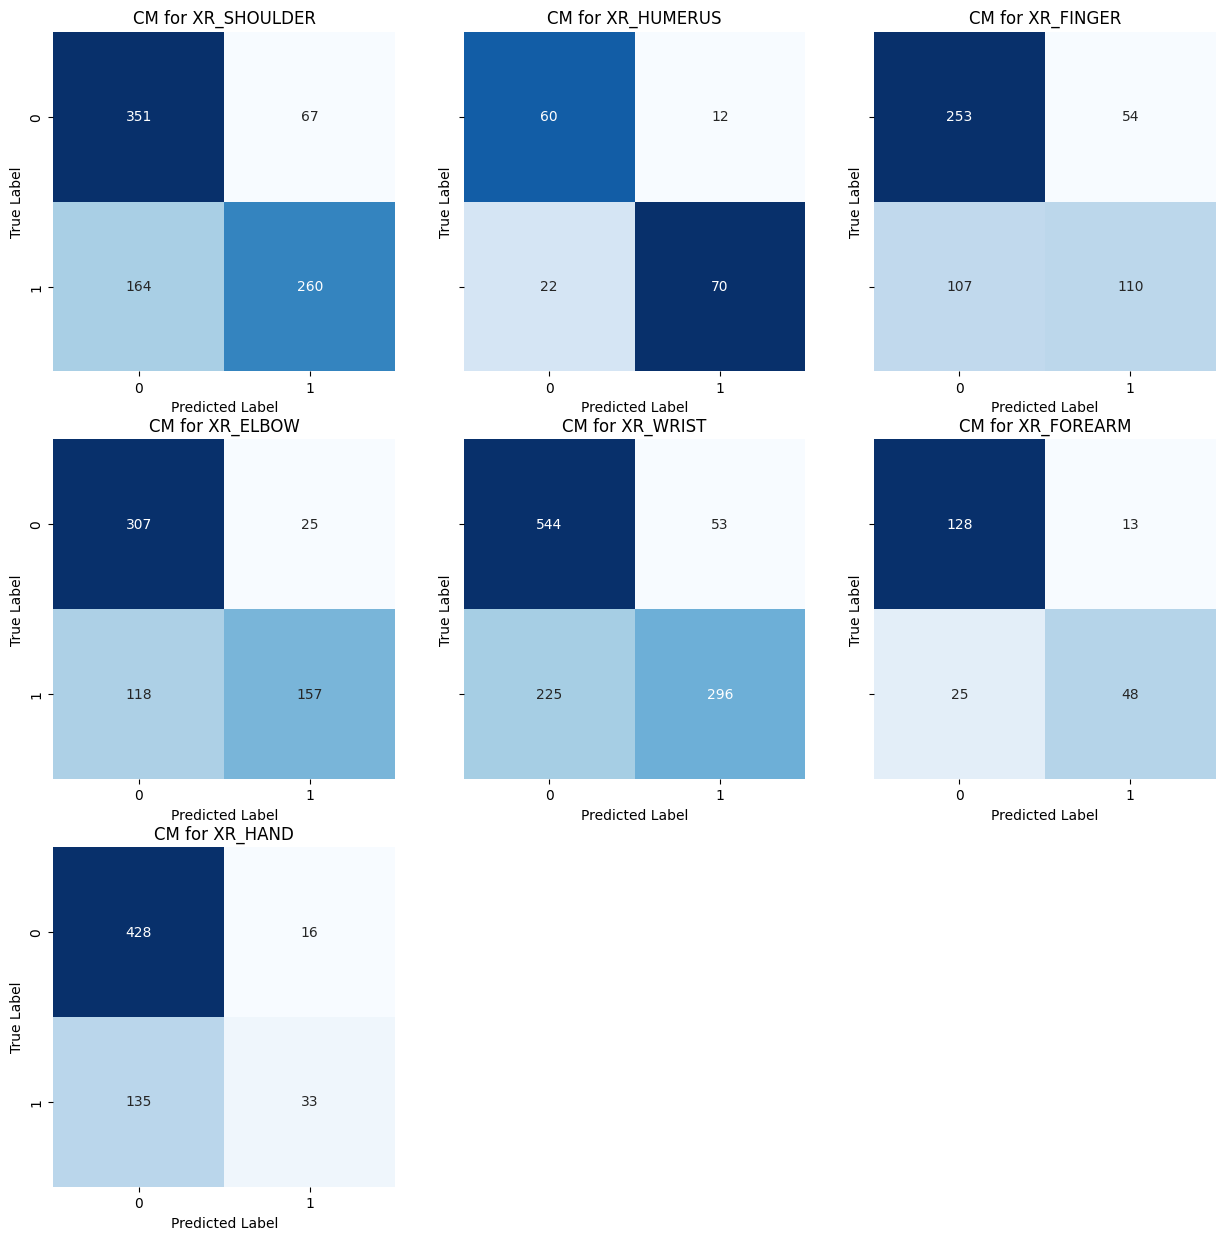

In [33]:
plot_cm(test_df_extra_after_prediction,segment = True)

We observe an improvement in some of the anatomies in comparison to the pretrained finetuned model.
More specific:
- Shoulder has much more TP and TN
- Humerus also has improved in both TP and TN
- Finger has improved minimally with a bit increased TP
- Elbow, wrist and forearm are very similar as with the pretrained model
- Finger has a bit more TP

In [34]:
study_df = test_df_extra_after_prediction.groupby(['patient', 'anatomy', 'path']).agg({
    'predicted_label': ['mean', 'max'], 
    'labels': 'min'
})  

study_df.columns = ['_'.join(col).rstrip('_') for col in study_df.columns.values]
study_df['pred_binary_mean'] = np.where(study_df['predicted_label_mean'] > 0.5, 1, 0)
study_df['pred_binary_max'] = np.where(study_df['predicted_label_max'] > 0.5, 1, 0) # at least one is wrong then all are wrong

# 

### Analysis of F1 score and ROC-AUC on a per study basis

In [36]:
# Aggregate Level
f1_aggregate, roc_auc_aggregate = hp.calculate_metrics(study_df['labels_min'], study_df['pred_binary_mean'], study_df['predicted_label_max'])

print("Aggregate Level:")
print(f"F1 Score: {f1_aggregate:.4f}, ROC AUC: {roc_auc_aggregate:.4f}")

Aggregate Level:
F1 Score: 0.6815, ROC AUC: 0.8418


The model has improved F1 score and ROC AUC achieving 84%

### Analysis of F1 score and ROC-AUC per anatomy

In [37]:
# Per Anatomy Level
metrics_per_anatomy = study_df.groupby('anatomy').apply(
    lambda x: pd.Series(calculate_metrics(x['labels_min'], x['pred_binary_mean'], x['predicted_label_max']), index=['F1', 'ROC AUC'])
)

print("\nPer Anatomy Level:")
print(metrics_per_anatomy)


Per Anatomy Level:
                   F1   ROC AUC
anatomy                        
XR_ELBOW     0.655738  0.865717
XR_FINGER    0.617886  0.819034
XR_FOREARM   0.771930  0.862772
XR_HAND      0.294118  0.773198
XR_HUMERUS   0.843373  0.871242
XR_SHOULDER  0.716535  0.813743
XR_WRIST     0.715789  0.856269


F1 score has improved for all anatomies in relation to the pretrained model apart from Elbow and Forearm.

ROC AUC is better in all anatomies apart from wrist with the biggest improvements observed in Shoulder and Humerus.

### Challenges - Improvements

Overall, the projects were interesting and challenging in their own ways. The MURA project is a very difficult problem to be solved and we tried different methodologies that were inspired by others or by experimentation.

Still, computational power is key in order to be able to experiment and run efficiently DL models and that we lacked. 
Furthermore, tensorflow caused us many headaches and incompatibilities when models were run in different systems.

As for the possible improvements we can list a few interesting routes that maybe the basis for future work:

- Hierarchical model for body part classification and secondly image classification for normal and abnormal cases
- Data augmentation for the minority class , as well as for the body parts with less images
- Ensembling of models to improve performance
- Hyperparameter tuning